# Here we investigate the changes in error and bias when using bio-optical models outside of their training domain



We also build a couple figures for supplemental materials

In [1]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from sklearn.linear_model import LinearRegression

import cartopy.crs as crs

In [38]:
plt.rcParams.update({'font.size': 18})

Pull the NASA NOMAD data straight from SeaBASS

In [2]:
df = pd.read_csv('https://seabass.gsfc.nasa.gov/wiki/NOMAD/nomad_seabass_v2.a_2008200.txt', skiprows=list(range(0,88)) + [89,90])
df = df.rename(columns={'/fields=year': 'year'})

print(df.shape)
df.head()

(4459, 217)


,year,month,day,hour,minute,second,lat,lon,id,oisst,...,allo,diato,lut,zea,chl_b,beta-car,alpha-car,alpha-beta-car,flag,cruise
0,2003,4,15,15,15,0,38.4279,-76.61,1565,3.70,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,20691,ace0301
1,2003,4,15,16,50,0,38.3680,-76.50,1566,3.70,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,20675,ace0301
2,2003,4,15,17,50,0,38.3074,-76.44,1567,3.70,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,20691,ace0301
3,2003,4,17,18,15,0,38.6367,-76.32,1568,3.70,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,20675,ace0301
4,2003,7,21,18,27,0,38.3047,-76.44,1559,22.03,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,20691,ace0302


wrangle the data

In [3]:
blue_lw =   'lw443'
blue_es =   'es443'
blue_rrs =  'rrs443'

green_lw =  'lw555'
green_es =  'es555'
green_rrs = 'rrs555'

red_lw =    'lw670'
red_es =    'es670'
red_rrs =   'rrs670'

In [4]:
def chl_fcn(row):
   if row['chl_a'] != -999 :
      return (row['chl_a']) # HPLC
   else:
     return (row['chl']) # flu

df['chl_merge'] = df.apply(lambda row: chl_fcn(row), axis=1)

# whether to use only HPLC or merged chl
# Hu et al 2012 only use HPLC which is chl_a
chl = 'chl_merge' # 'chl_merge'

In [5]:
# make a copy to subset
df_chl = df.copy()

# create the rrs columns
df_chl[blue_rrs] = df_chl[blue_lw]/df_chl[blue_es]

df_chl[blue_rrs] = ((df_chl[blue_lw]/df_chl[blue_es])*.5 + (df_chl['lw489']/df_chl['es489'])*1.5)/2
df_chl[green_rrs] = df_chl[green_lw]/df_chl[green_es]
df_chl[red_rrs] = df_chl[red_lw]/df_chl[red_es]

# subset to delete any measurements that are missing
# filter to ensure all the SeaWiFS bands are present
df_chl = df_chl[df_chl['lw443'] != -999]
df_chl = df_chl[df_chl['lw555'] != -999]
df_chl = df_chl[df_chl['lw670'] != -999]
df_chl = df_chl[df_chl['es443'] != -999]
df_chl = df_chl[df_chl['es555'] != -999]
df_chl = df_chl[df_chl['es670'] != -999]
df_chl = df_chl[df_chl['lat'] != -999]
df_chl = df_chl[df_chl['etopo2'] != -999]
df_chl = df_chl[df_chl['lw411'] != -999]
df_chl = df_chl[df_chl['es411'] != -999]
df_chl = df_chl[df_chl['lw489'] != -999]
df_chl = df_chl[df_chl['es489'] != -999]
df_chl = df_chl[df_chl['lw510'] != -999]
df_chl = df_chl[df_chl['es510'] != -999]

df_chl = df_chl[df_chl[chl] != -999]

# subset to only rows that were deeper than 30m
df_chl = df_chl[df_chl['etopo2'] > 30]

# subset to lat between 60N and 60S
df_chl = df_chl[(df_chl['lat'] < 60) & (df_chl['lat'] > -60)]

print("Number of rows remaning after filters: ", len(df_chl))

Number of rows remaning after filters:  487


In [6]:
# there is one row that has a red Rrs of 0 which was suspicious but I assume just too low for the instrument to measure
df_chl[df_chl[red_rrs] <= 0.0][[red_es, red_lw, green_lw, blue_lw, chl]]

,es670,lw670,lw555,lw443,chl_merge
1125,93.047,0.0,0.0966,0.5361,0.13400
1238,97.940,0.0,0.1809,0.7167,0.19050
1239,72.465,0.0,0.1152,0.4510,0.17870
1240,50.718,0.0,0.0673,0.2843,0.18550
1246,115.000,0.0,0.2273,0.8278,0.14900
1248,73.267,0.0,0.1332,0.4724,0.17350
1277,73.901,0.0,0.1177,0.4700,0.13261
1298,132.162,0.0,0.2012,1.2211,0.07083
1321,126.144,0.0,0.2803,1.0329,0.14194
1322,109.704,0.0,0.2297,0.9380,0.09885


In [7]:
df_chl[df_chl['chl_merge']<0.15][[blue_rrs, green_rrs, 'chl_merge']]

,rrs443,rrs555,chl_merge
14,0.004281,0.001470,0.091000
15,0.004869,0.001534,0.079000
1021,0.006714,0.001733,0.112713
1023,0.005572,0.001671,0.122705
1123,0.005325,0.002300,0.149000
...,...,...,...
4063,0.005000,0.001300,0.106290
4068,0.005125,0.001200,0.117770
4070,0.004950,0.001300,0.114300
4071,0.005225,0.001200,0.093540


In [8]:
CI = df_chl[green_rrs] - ((df_chl[blue_rrs]) + (555 - 477)/(670 - 477) * (df_chl[red_rrs] - df_chl[blue_rrs]))

In [9]:
CI_subset = np.array(CI[CI <= -0.0005])
chla_subset = np.array(df_chl[CI <= -0.0005][chl])

df_chl_subset = df_chl[CI <= -0.0005]

# how many do we have after this subsetting?
CI_subset.shape

(220,)

Build the Hull using NOMAD data

In [11]:
def in_hull(p, hull):
    """
    Test if points in `p` are in `hull`

    `p` should be a `NxK` coordinates of `N` points in `K` dimensions
    `hull` is either a scipy.spatial.Delaunay object or the `MxK` array of the 
    coordinates of `M` points in `K`dimensions for which Delaunay triangulation
    will be computed
    """
    from scipy.spatial import Delaunay
    if not isinstance(hull,Delaunay):
        hull = Delaunay(hull)

    return hull.find_simplex(p)>=0
    
x = df_chl.rrs443
y = df_chl.rrs555

pts = np.array([x,y])
pts = pts.T[~np.isnan(pts).any(axis=0)]

# go through the points, if they don't have a neighbor within 30% of their value then throw them out, then make a convex hull

import math
def get_dist(a,b):
  return math.sqrt((a[0]-b[0])**2 + (a[1]-b[1])**2)

np_list = []
for i in range(len(pts)):
    dist = math.inf #(infinity)
    npidx = 0
    for j in range(len(pts)):
       d = get_dist(pts[i],pts[j])
       if d<dist and d!=0: # to avoid the same point
          dist =d
          npidx = j
    np_list.append(dist)

mean_val = pts.mean(axis=1)

dist_ratio = np_list/mean_val
dist_ratio[dist_ratio > 0.1]

array([0.10639886, 0.14633462, 0.19910241, 0.98108921, 0.21852454,
       0.23408196, 0.10073796, 0.15939571, 0.10618461, 0.15196234,
       0.38627513, 0.16623866, 0.10194499, 0.20440559, 0.328114  ,
       0.15025555, 0.79061777, 0.11212677, 0.11956954, 0.13047427,
       0.24653636, 0.18570092, 0.16111612, 0.12592557, 0.15622643,
       0.10834434, 0.10639886, 0.14633462, 0.19910241, 0.98108921,
       0.10009949, 0.19288051, 0.16577723, 0.17290904, 0.11727478,
       0.18648521, 0.10416192, 0.15198432, 0.14977246, 0.1354801 ,
       0.18455965, 0.126266  , 0.10904639, 0.14764964, 0.12784735,
       0.16997536, 0.18411681, 0.34771846, 0.12019509])

In [12]:
valente_df = pd.read_csv("data/valente_chla_rrs_v3.csv")

In [14]:
valente_df.columns

Index(['ID (idx)', '412.4', '442.1', '490.0', '530.6', '551.1', '667.7',
       '681.0', '748.0', '869.9', 'Date/Time', 'Latitude', 'Longitude',
       'Chl a [mg/m**3] (High Performance Liquid Chrom...)',
       'Chl a [mg/m**3] (Chlorophyll a, fluorometric o...)',
       'Depth water [m] (water depth from ETOPO1, if >...)',
       'Comment (chla_hplc_dataset)', 'Comment (chla_hplc_subdataset)',
       'Comment (chla_hplc_contributor)', 'Comment (chla_fluor_dataset)',
       'Comment (chla_fluor_subdataset)', 'Comment (chla_fluor_contributor)',
       'QF time (1 if observation without time...)',
       'QF Chl (1 if observation as unknown c...)', 'chla'],
      dtype='object')

In [29]:
val_gdf = gpd.GeoDataFrame(
    valente_df, geometry=gpd.points_from_xy(valente_df.Longitude, valente_df.Latitude), crs="EPSG:4326"
)

nomad_gdf = gpd.GeoDataFrame(
    df_chl, geometry=gpd.points_from_xy(df_chl.lon, df_chl.lat), crs="EPSG:4326"
)

In [66]:
nomad_gdf['doy'] = pd.to_datetime(nomad_gdf[['year', 'month', 'day']]).dt.dayofyear

In [67]:
val_gdf['doy'] = pd.to_datetime(val_gdf['Date/Time']).dt.dayofyear

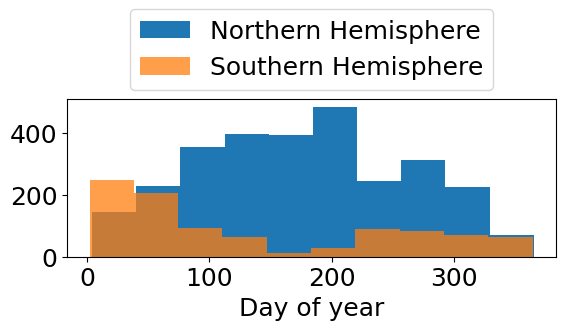

In [124]:
fig, ax = plt.subplots(figsize=(6,5.25))
ax.hist(val_gdf[val_gdf.Latitude>0]['doy'],label='Northern Hemisphere')
ax.hist(val_gdf[val_gdf.Latitude<0]['doy'],alpha=0.75,label='Southern Hemisphere')

ax.set_xlabel('Day of year')

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.65))

fig.tight_layout()

plt.savefig('nomad_valente_time_distributons.png',dpi=300)

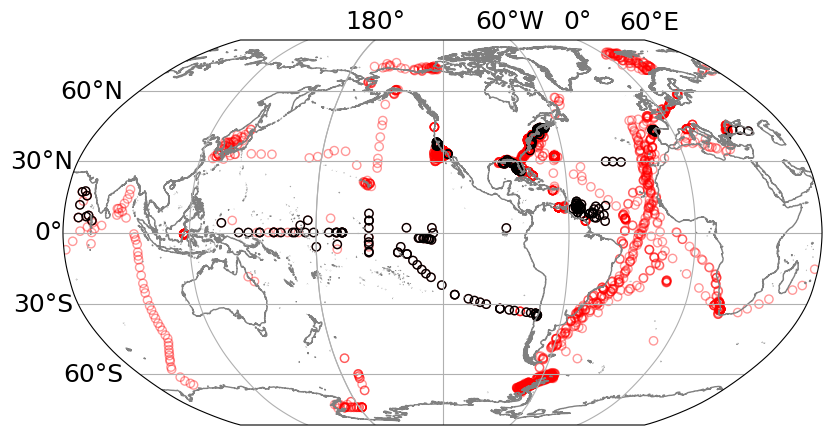

In [42]:
# fig, ax = plt.subplots(figsize=(12,5), subplot_kw=dict(projection=crs.PlateCarree()))
fig, ax = plt.subplots(figsize=(12,5), subplot_kw=dict(projection=crs.Robinson(central_longitude=-120)))
ax.coastlines(resolution='10m',color='grey')
# ds.count_map_normalized.plot(ax=ax, x='lon', y='lat', cmap='viridis', vmin=0.0,vmax=1, transform=crs.PlateCarree())
gl = ax.gridlines(draw_labels=True)
gl.bottom_labels=False   # suppress top labels
gl.right_labels=False # suppress right labels


robinson = crs.Robinson(central_longitude=-120).proj4_init
val_gdf.to_crs(robinson).plot(ax=ax,facecolor='none', edgecolor='r', alpha=0.4, label='Valente')

nomad_gdf.to_crs(robinson).plot(ax=ax,facecolor='none', edgecolor='k', alpha=1, label='Valente')

# ax.set_xlim(-90,-20)
# ax.set_ylim(10,60)

# ax.set_xlim(-90,-20)
# ax.set_ylim(10,60)


plt.savefig('nomad_valente_geo_distributons.png',dpi=300)

plt.show()

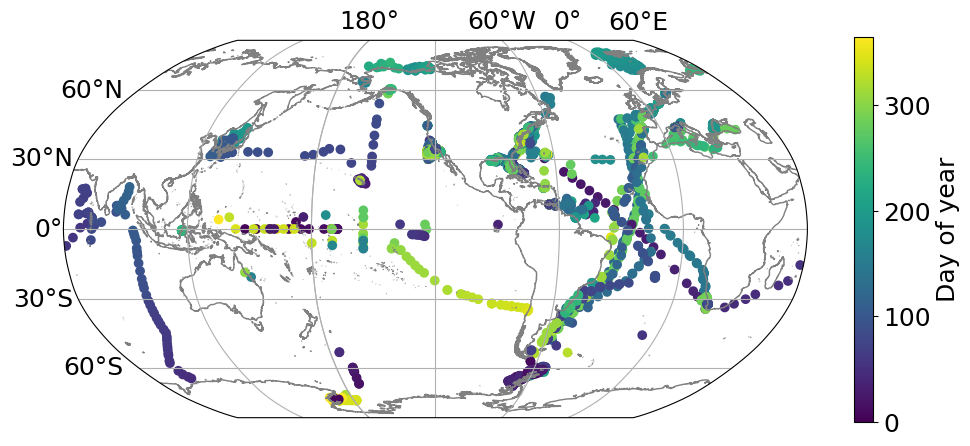

In [118]:
# fig, ax = plt.subplots(figsize=(12,5), subplot_kw=dict(projection=crs.PlateCarree()))
fig, ax = plt.subplots(figsize=(12,5), subplot_kw=dict(projection=crs.Robinson(central_longitude=-120)))
ax.coastlines(resolution='10m',color='grey')
# ds.count_map_normalized.plot(ax=ax, x='lon', y='lat', cmap='viridis', vmin=0.0,vmax=1, transform=crs.PlateCarree())
gl = ax.gridlines(draw_labels=True)
gl.bottom_labels=False   # suppress top labels
gl.right_labels=False # suppress right labels


robinson = crs.Robinson(central_longitude=-120).proj4_init
val_gdf.to_crs(robinson).plot(ax=ax,column='doy',vmin=0,vmax=365,legend=True,legend_kwds={'label':'Day of year'})


# ax.set_xlim(-90,-20)
# ax.set_ylim(10,60)

# ax.set_xlim(-90,-20)
# ax.set_ylim(10,60)


plt.savefig('nomad_valente_time_geo_distributons.png',dpi=300)

plt.show()

/tmp/ipykernel_113/1075823797.py:13: RuntimeWarning: All-NaN axis encountered
  ax.scatter(x = np.nanmax([valente_df['442.1'],valente_df['490.0']],axis=0),


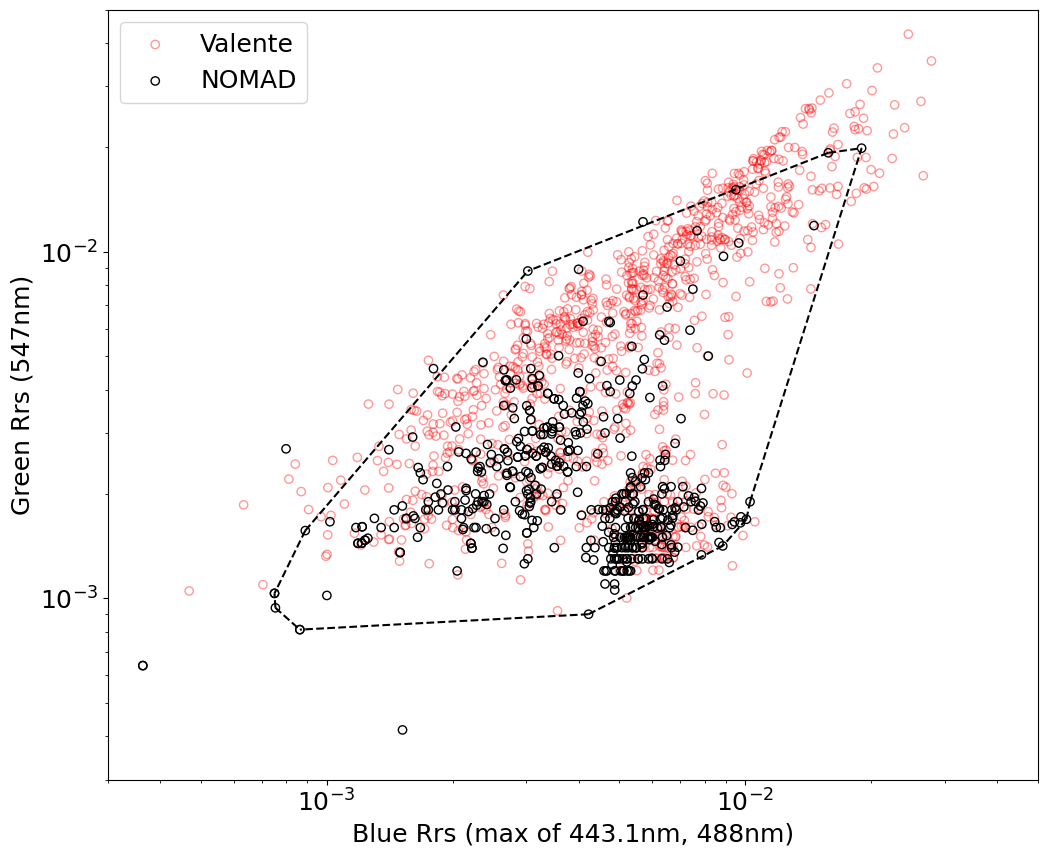

In [46]:
skip_num = 1
fig, ax = plt.subplots(figsize=(12,10))

# hb = ax.hexbin(x = np.max([modis_global.Rrs_443.values.flatten()[::skip_num],
#                        modis_global.Rrs_488.values.flatten()[::skip_num]],axis=0), 
#            y = modis_global.Rrs_555.values.flatten()[::skip_num],
#           yscale='log',xscale='log',
#          gridsize=30,
#           bins='log',
#          cmap='Blues')
# fig.colorbar(hb)

ax.scatter(x = np.nanmax([valente_df['442.1'],valente_df['490.0']],axis=0),
           y = valente_df['551.1'], facecolor='none', edgecolor='r', alpha=0.4, label='Valente')

ax.scatter(x = x,
           y = y, facecolor='none', edgecolor='k', alpha=1, label='NOMAD')

from scipy.spatial import ConvexHull, convex_hull_plot_2d

hull = ConvexHull(pts[dist_ratio < 0.2])

for simplex in hull.simplices:
    ax.plot(pts[dist_ratio < 0.2][simplex, 0], pts[dist_ratio < 0.2][simplex, 1], 'k--')

ax.set_ylim(0.0003,0.05)
ax.set_xlim(0.0003,0.05)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Blue Rrs (max of 443.1nm, 488nm)')
ax.set_ylabel('Green Rrs (547nm)')
# ax.set_title('Valente ConvexHull')

ax.legend()

# plt.axhline(0.002)
# plt.axvline(0.01)

# plt.axhline(0.001)
# plt.axvline(0.005)
plt.savefig('nomad_valente_rrs_distributons.png',dpi=300)

plt.show()

In [20]:
# calculate the bias in chla vs the distance in rrs phase space from the hull

In [21]:
def oc3_chlor_a(Rrs443, Rrs488, Rrs547):
    ''' oc3m  algorithm '''

    a0 = 0.2424
    a1 = -2.7423
    a2 = 1.8017
    a3 = 0.0015
    a4 = -1.2280
    
    Rrsblue = np.maximum(Rrs443,Rrs488)

    log10chl = a0 + a1 * (np.log10(Rrsblue / Rrs547)) \
        + a2 * (np.log10(Rrsblue / Rrs547))**2 \
            + a3 * (np.log10(Rrsblue / Rrs547))**3 \
                + a4 * (np.log10(Rrsblue / Rrs547))**4

    oc3m = np.power(10, log10chl)

    return oc3m

In [22]:
chla_estimates = oc3_chlor_a(valente_df['442.1'].values, valente_df['490.0'].values, valente_df['551.1'].values)

(array([765., 189.,  41.,   9.,   9.,   3.,   1.,   2.,   2.,   3.]),
 array([2.97745730e-02, 7.28457712e+00, 1.45393797e+01, 2.17941822e+01,
        2.90489847e+01, 3.63037873e+01, 4.35585898e+01, 5.08133924e+01,
        5.80681949e+01, 6.53229975e+01, 7.25778000e+01]),
 <BarContainer object of 10 artists>)

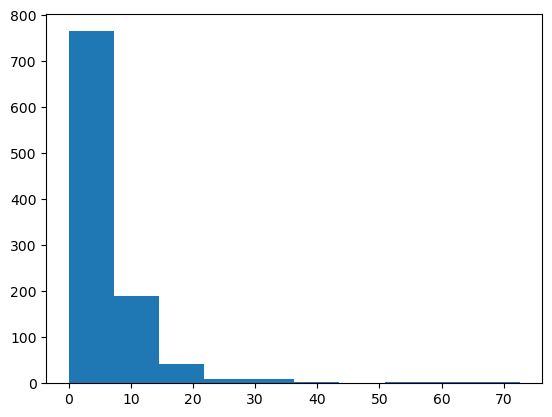

In [23]:
plt.hist(chla_estimates)

In [24]:
val_x = np.nanmax([valente_df['442.1'],valente_df['490.0']],axis=0)
val_y = valente_df['551.1']

/tmp/ipykernel_1362/3533140575.py:1: RuntimeWarning: All-NaN axis encountered
  val_x = np.nanmax([valente_df['442.1'],valente_df['490.0']],axis=0)


In [2]:
gdf_merge = gpd.read_feather('data/sopace_rrs_acs_merge.feather')

In [3]:
gdf_merge

,ps_lat,ps_lon,ps_sza,ps_rrs353.0,ps_rrs356.3,ps_rrs359.6,ps_rrs362.9,ps_rrs366.2,ps_rrs369.5,ps_rrs372.8,...,agaus-mae,POC_cp,ap676_lh,Chl_lineheight,cp_gamma,Halh,chl_Halh,HH_G50,HH_mphi,flag_bit
utc_dt,,,,,,,,,,,,,,,,,,,,,
2024-10-24 21:11:58+00:00,18.4663,-156.9595,34.0,0.011942,0.012413,0.012789,0.013266,0.013544,0.013708,0.013678,...,0.000087,13.683869,0.001315,0.047955,1.047869,0.011772,0.695581,5.222098,-3.427884,5.497558e+11
2024-10-24 21:37:04+00:00,18.3973,-156.9357,31.7,0.012039,0.012513,0.012922,0.013417,0.013711,0.013871,0.013849,...,0.000071,14.392297,0.001270,0.045987,0.987106,0.011781,0.696194,5.218739,-3.427395,5.497558e+11
2024-10-24 21:41:30+00:00,18.3860,-156.9311,31.4,0.012162,0.012611,0.013030,0.013520,0.013815,0.013981,0.013962,...,0.000083,14.595411,0.001278,0.046321,1.005508,0.009947,0.566326,4.708097,-3.513365,5.497558e+11
2024-10-24 21:46:31+00:00,18.3712,-156.9251,31.1,0.012067,0.012543,0.012939,0.013411,0.013689,0.013838,0.013827,...,0.000088,14.801107,0.001235,0.044423,1.022295,0.010424,0.599648,4.918062,-3.473408,5.497558e+11
2024-10-24 21:51:25+00:00,18.3584,-156.9200,30.9,0.011775,0.012258,0.012639,0.013081,0.013359,0.013517,0.013529,...,0.000078,14.623078,0.001182,0.042102,1.010520,0.010131,0.579156,4.817113,-3.490650,5.497558e+11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-16 00:37:30+00:00,20.8806,-157.7776,54.4,0.006344,0.006648,0.006897,0.007257,0.007448,0.007596,0.007637,...,0.000063,15.389090,0.001360,0.049997,1.004559,0.009215,0.515904,4.442727,-3.559812,5.497558e+11
2024-12-16 00:42:48+00:00,20.8942,-157.7819,55.1,0.006779,0.007063,0.007320,0.007683,0.007905,0.008050,0.008096,...,0.000080,15.781073,0.001339,0.049022,1.003423,0.009129,0.510030,4.427288,-3.561679,5.497558e+11
2024-12-16 00:47:34+00:00,20.9089,-157.7865,55.9,0.006401,0.006733,0.006978,0.007322,0.007555,0.007759,0.007771,...,0.000062,15.458091,0.001490,0.055887,1.002296,0.010149,0.580425,4.741161,-3.511101,5.497558e+11


In [26]:
pvst_x = np.nanmax([gdf_merge['ps_rrs442.1'],gdf_merge['ps_rrs488.3']],axis=0)
pvst_y = gdf_merge['ps_rrs551.0']

In [27]:
chla_estimates = oc3_chlor_a(gdf_merge['ps_rrs442.1'], gdf_merge['ps_rrs488.3'], gdf_merge['ps_rrs551.0'])

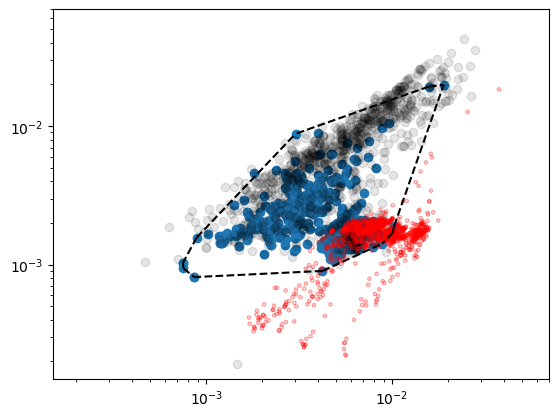

In [28]:
fig, ax = plt.subplots()
plt.scatter(hull.points[:,0], hull.points[:,1])

for simplex in hull.simplices:
    ax.plot(pts[dist_ratio < 0.2][simplex, 0], pts[dist_ratio < 0.2][simplex, 1], 'k--')

plt.scatter(val_x,val_y,c='k', alpha=0.1)

ax.scatter(x = np.nanmax([gdf_merge['ps_rrs442.1'],gdf_merge['ps_rrs488.3']],axis=0),
           y = gdf_merge['ps_rrs551.0'], facecolor='none', edgecolor='r', alpha=0.4, label='SOPACE',s=5)

ax.set_ylim(0.00015,0.07)
ax.set_xlim(0.00015,0.07)
ax.set_xscale('log')
ax.set_yscale('log')

In [29]:
import math

def dot(v,w):
    x,y = v
    X,Y = w
    return x*X + y*Y

def length(v):
    x,y = v
    return math.sqrt(x*x + y*y)

def vector(b,e):
    x,y = b
    X,Y = e
    return (X-x, Y-y)

def unit(v):
    x,y = v
    mag = length(v)
    return (x/mag, y/mag)

def distance(p0,p1):
    return length(vector(p0,p1))

def scale(v,sc):
    x,y = v
    return (x * sc, y * sc)

def add(v,w):
    x,y = v
    X,Y = w
    return (x+X, y+Y)

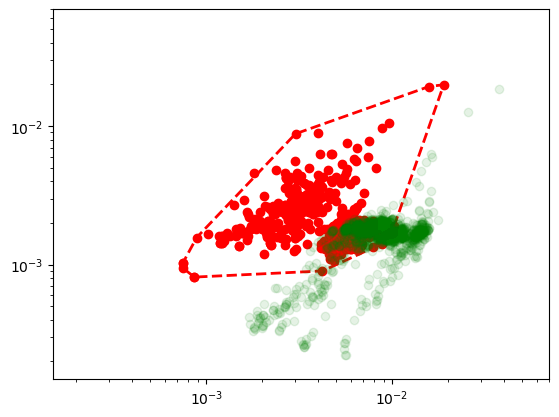

In [30]:
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
import numpy as np

def pnt2line(pnt, start, end):
    line_vec = vector(start, end)
    pnt_vec = vector(start, pnt)
    line_len = length(line_vec)
    line_unitvec = unit(line_vec)
    pnt_vec_scaled = scale(pnt_vec, 1.0/line_len)
    t = dot(line_unitvec, pnt_vec_scaled)    
    if t < 0.0:
        t = 0.0
    elif t > 1.0:
        t = 1.0
    nearest = scale(line_vec, t)
    dist = distance(nearest, pnt_vec)
    nearest = add(nearest, start)
    return (dist, nearest)

def point_in_poly(x,y,poly):

    n = len(poly)
    inside = False

    p1x,p1y = poly[0]
    for i in range(n+1):
        p2x,p2y = poly[i % n]
        if y > min(p1y,p2y):
            if y <= max(p1y,p2y):
                if x <= max(p1x,p2x):
                    if p1y != p2y:
                        xints = (y-p1y)*(p2x-p1x)/(p2y-p1y)+p1x
                    if p1x == p2x or x <= xints:
                        inside = not inside
        p1x,p1y = p2x,p2y

    return inside

newpoints = np.array([pvst_x,pvst_y]).T
points = pts[dist_ratio < 0.2]

pt_dist = []
for p_idx in range(len(newpoints)):
    pt = newpoints[p_idx,:]
    dist_list = []
    for v_idx in range(len(hull.vertices)):
        v1 = hull.vertices[v_idx - 1]
        v2 = hull.vertices[v_idx]
        start = points[v1]
        end = points[v2]
        temp = pnt2line(pt, start, end)
        dist_list.append(temp[0])

    #Check point is within polygon
    inside =  point_in_poly(pt[0],pt[1],points[hull.vertices])
    if (inside == True):
        dist_temp = -1. * min(dist_list)
    else:
        dist_temp = min(dist_list)          

    pt_dist.append(dist_temp)


# Plot original points, hull and new points
plt.plot(points[:,0], points[:,1], 'ro')
plt.plot(points[hull.vertices,0], points[hull.vertices,1], 'r--', lw=2)
plt.plot(newpoints[:,0], newpoints[:,1], 'go',alpha=0.1)
# for p_idx in range(30):
#     pt = newpoints[p_idx,:]
#     pt[1] = pt[1] + 0.01 
#     dist = pt_dist[p_idx]
#     distLabel = "%.2f" % dist
#     plt.annotate(distLabel,xy=pt)

plt.ylim(0.00015,0.07)
plt.xlim(0.00015,0.07)
plt.xscale('log')
plt.yscale('log')

/tmp/ipykernel_1362/3414347536.py:1: RuntimeWarning: invalid value encountered in log10
  plt.hist(np.log10(np.array(pt_dist)))


(array([  2.,   0.,   0.,   5.,  10.,  31.,  91., 199., 271.,  10.]),
 array([-7.64076362, -7.0495114 , -6.45825918, -5.86700695, -5.27575473,
        -4.68450251, -4.09325029, -3.50199806, -2.91074584, -2.31949362,
        -1.7282414 ]),
 <BarContainer object of 10 artists>)

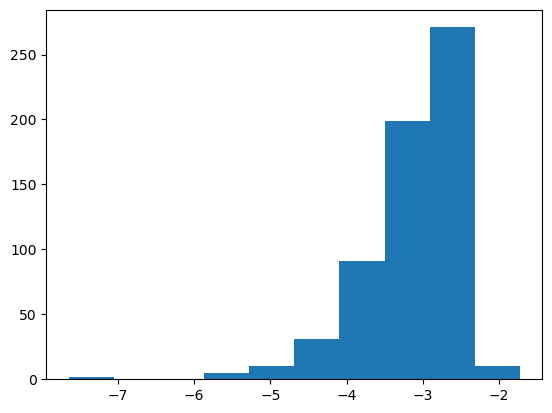

In [31]:
plt.hist(np.log10(np.array(pt_dist)))

/tmp/ipykernel_1362/2284183932.py:6: RuntimeWarning: invalid value encountered in log10
  cb = plt.scatter(newpoints[:,0][~np.isnan(np.array(pt_dist))], newpoints[:,1][~np.isnan(np.array(pt_dist))], c=np.log10(np.array(pt_dist)[~np.isnan(np.array(pt_dist))]),vmin=-4.5,vmax=-2)


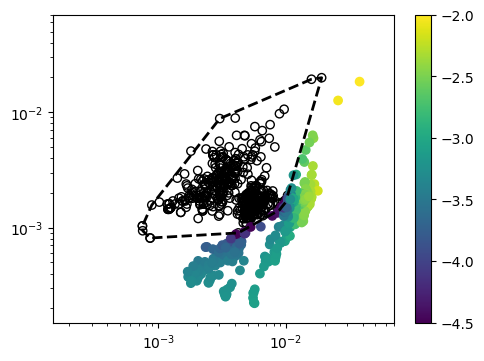

In [32]:
fig, ax = plt.subplots(figsize=(5.5,4))

# plt.plot(points[:,0], points[:,1], 'ro')
plt.scatter(points[:,0], points[:,1], edgecolor='k', facecolor='none')
plt.plot(points[hull.vertices,0], points[hull.vertices,1], 'k--', lw=2)
cb = plt.scatter(newpoints[:,0][~np.isnan(np.array(pt_dist))], newpoints[:,1][~np.isnan(np.array(pt_dist))], c=np.log10(np.array(pt_dist)[~np.isnan(np.array(pt_dist))]),vmin=-4.5,vmax=-2)
plt.colorbar(cb)
# for p_idx in range(30):
#     pt = newpoints[p_idx,:]
#     pt[1] = pt[1] + 0.01 
#     dist = pt_dist[p_idx]
#     distLabel = "%.2f" % dist
#     plt.annotate(distLabel,xy=pt)

plt.ylim(0.00015,0.07)
plt.xlim(0.00015,0.07)
plt.xscale('log')
plt.yscale('log')

plt.savefig('validation_data_example.png',dpi=300)

(array([178.,  98.,  57.,  26.,  12.,  17.,  27.,  57.,  66.,  34.,  22.,
         15.,   6.,   1.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,
          1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   1.,   0.,   0.,   0.]),
 array([0.    , 0.0004, 0.0008, 0.0012, 0.0016, 0.002 , 0.0024, 0.0028,
        0.0032, 0.0036, 0.004 , 0.0044, 0.0048, 0.0052, 0.0056, 0.006 ,
        0.0064, 0.0068, 0.0072, 0.0076, 0.008 , 0.0084, 0.0088, 0.0092,
        0.0096, 0.01  , 0.0104, 0.0108, 0.0112, 0.0116, 0.012 , 0.0124,
        0.0128, 0.0132, 0.0136, 0.014 , 0.0144, 0.0148, 0.0152, 0.0156,
        0.016 , 0.0164, 0.0168, 0.0172, 0.0176, 0.018 , 0.0184, 0.0188,
        0.0192, 0.0196, 0.02  ]),
 <BarContainer object of 50 artists>)

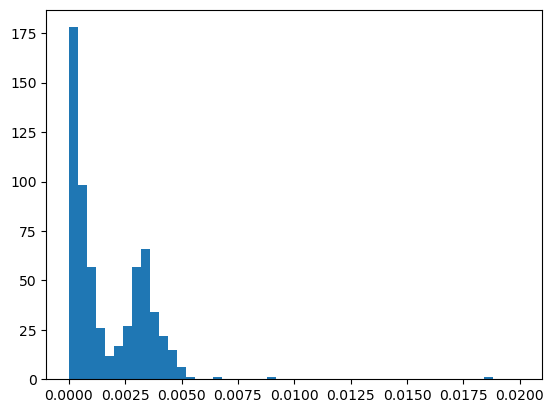

In [33]:
plt.hist(pt_dist, range=[0,0.02],bins=50)

/tmp/ipykernel_1362/3584150624.py:3: RuntimeWarning: invalid value encountered in log
  plt.scatter(gdf_merge.Chl_lineheight,chla_estimates, c=np.log(pt_dist))


(0.01, 0.5)

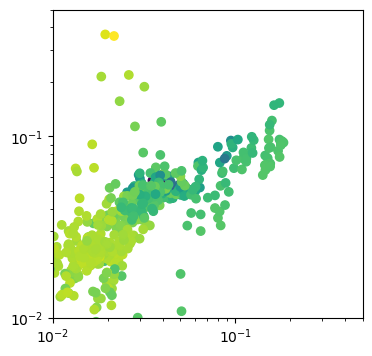

In [34]:
fig, ax = plt.subplots(figsize=(4,4))

plt.scatter(gdf_merge.Chl_lineheight,chla_estimates, c=np.log(pt_dist))
plt.xscale('log')
plt.yscale('log')
plt.xlim(0.01,.5)
plt.ylim(0.01,.5)

In [35]:
len(chla_estimates)

1677

In [4]:
import sklearn 

In [36]:

mape = sklearn.metrics.mean_absolute_percentage_error(gdf_merge.Chl_lineheight[~np.isnan(gdf_merge.Chl_lineheight)].values.reshape(1,-1), chla_estimates[~np.isnan(gdf_merge.Chl_lineheight)].values.reshape(1,-1), multioutput='raw_values')

In [37]:
pt_dist_sub = np.array(pt_dist)[~np.isnan(gdf_merge.Chl_lineheight)]

In [38]:
np.nanmean(mape[pt_dist_sub<0]), np.nanmedian(mape[pt_dist_sub<0]), np.nanstd(mape[pt_dist_sub<0])

(0.37289456609041943, 0.375433329348559, 0.22409360710021925)

In [39]:
np.nanmean(mape[pt_dist_sub>0]), np.nanmedian(mape[pt_dist_sub>0]), np.nanstd(mape[pt_dist_sub>0])

(0.6256876112219348, 0.3995390271627423, 1.2765257538331283)

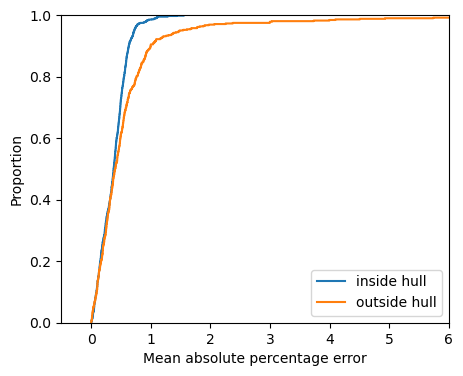

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(5,4))

# Create the ECDF plot
sns.ecdfplot(x=mape[pt_dist_sub<0], label='inside hull')
sns.ecdfplot(x=mape[pt_dist_sub>0], label='outside hull')

plt.xlabel('Mean absolute percentage error')

plt.legend(loc='lower right')

plt.xlim(-0.5,6)
plt.ylim(0,1.002)

plt.savefig('ecdf_in_out_hull.png',dpi=300)

In [ ]:
plt.scatter(np.array(pt_dist)[~np.isnan(gdf_merge.Chl_lineheight)],mape,alpha=0.2)
# plt.xlim(-13,-5)
plt.ylim(-.1,7)
# plt.yscale('log')
plt.xlabel('distance to convex hull edge')
plt.ylabel('mean absolute percent error')
plt.axvline(0,c='k',ls='--')

# plt.savefig('comparison_in_out_hull.png',dpi=300)

/tmp/ipykernel_541/4226702754.py:1: RuntimeWarning: invalid value encountered in log
  plt.scatter(np.log(-1*np.array(pt_dist)[~np.isnan(gdf_merge.Chl_lineheight)]),mape,alpha=0.2)


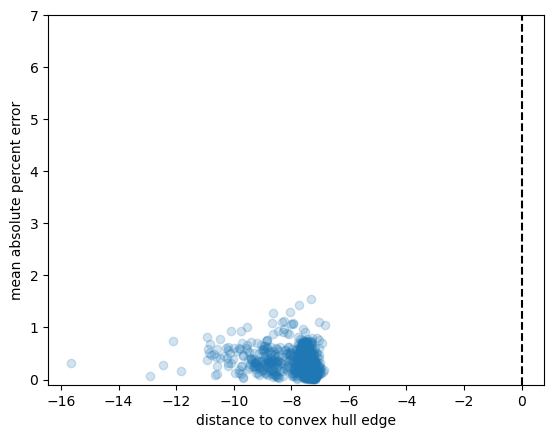

In [43]:
plt.scatter(np.log(-1*np.array(pt_dist)[~np.isnan(gdf_merge.Chl_lineheight)]),mape,alpha=0.2)
# plt.xlim(-13,-5)
plt.ylim(-.1,7)
# plt.yscale('log')
plt.xlabel('distance to convex hull edge')
plt.ylabel('mean absolute percent error')
plt.axvline(0,c='k',ls='--')

# plt.savefig('comparison_in_out_hull.png',dpi=300)

/tmp/ipykernel_541/902564203.py:1: RuntimeWarning: invalid value encountered in log10
  plt.scatter(np.log10(np.array(pt_dist)[~np.isnan(gdf_merge.Chl_lineheight)]),mape,alpha=0.25)


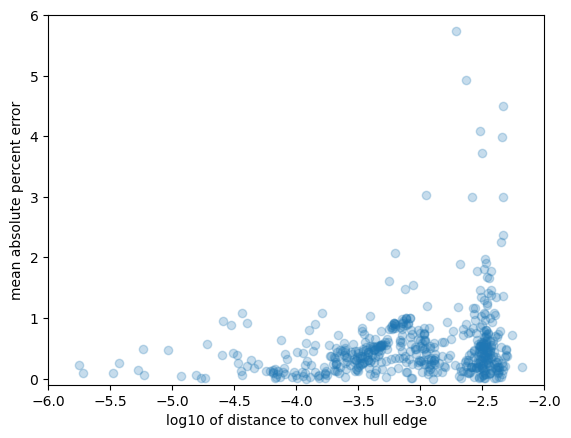

In [68]:
plt.scatter(np.log10(np.array(pt_dist)[~np.isnan(gdf_merge.Chl_lineheight)]),mape,alpha=0.25)
plt.xlim(-6,-2)
plt.ylim(-.1,6)
# plt.yscale('log')
plt.xlabel('log10 of distance to convex hull edge')
plt.ylabel('mean absolute percent error')

plt.savefig('comparison_in_out_hull.png',dpi=300)

In [1]:
def L2chlor_a(Rrs443, Rrs488, Rrs547, Rrs555, Rrs667):
    ''' Use weighted MODIS Aqua bands to calculate chlorophyll concentration
    using oc3m blended algorithm with CI (Hu et al. 2012) '''

    thresh = [0.15, 0.20]
    a0 = 0.2424
    a1 = -2.7423
    a2 = 1.8017
    a3 = 0.0015
    a4 = -1.2280

    ci1 = -0.4909
    ci2 = 191.6590
    
    if Rrs443 > Rrs488:
        Rrsblue = Rrs443
    else:
        Rrsblue = Rrs488

    log10chl = a0 + a1 * (np.log10(Rrsblue / Rrs547)) \
        + a2 * (np.log10(Rrsblue / Rrs547))**2 \
            + a3 * (np.log10(Rrsblue / Rrs547))**3 \
                + a4 * (np.log10(Rrsblue / Rrs547))**4

    oc3m = np.power(10, log10chl)

    CI = Rrs555 - ( Rrs443 + (555 - 443)/(667 - 443) * \
        (Rrs667 -Rrs443) )
        
    ChlCI = 10** (ci1 + ci2*CI)

    if ChlCI <= thresh[0]:
        chlor_a = ChlCI
    elif ChlCI > thresh[1]:
        chlor_a = oc3m
    else:
        chlor_a = oc3m * (ChlCI-thresh[0]) / (thresh[1]-thresh[0]) +\
            ChlCI * (thresh[1]-ChlCI) / (thresh[1]-thresh[0])

    return chlor_a